# Automating Inpainting Using Azure AI Services and Multi-Agent Architecture
Explore the construction and customization of multi-agent systems to automate inpainting tasks using Azure AI services. 

For more information on AutoGen, including tutorials and documentation, visit the following resources:

- [AutoGen GitHub Repository](https://github.com/microsoft/autogen) - Find the source code, examples, and more.
- [AutoGen Documentation](https://microsoft.github.io/autogen/docs/tutorial/introduction) - Explore detailed tutorials, API references, and an introduction to AutoGen.

In [1]:
import os

# Define the target directory
target_directory = r"C:\Users\pablosal\Desktop\gbbai-azure-ai-agentic-frameworks"  # change your directory here

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory changed to C:\Users\pablosal\Desktop\gbbai-azure-ai-agentic-frameworks


In [2]:
from dotenv import load_dotenv
import autogen
import os
from utils.ml_logging import get_logger
logger = get_logger()

# Load environment variables from a .env file
load_dotenv()

# Azure Open AI Completion Configuration
AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")
AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID = os.getenv("AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID")
AZURE_OPENAI_API_ENDPOINT = os.getenv("AZURE_OPENAI_API_ENDPOINT")
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")
API_KEY = os.getenv("AZURE_OPENAI_API_KEY")

llm_conf = {
    "config_list": [
        {
            "model": AZURE_AOAI_CHAT_MODEL_NAME_DEPLOYMENT_ID,
            "api_type": "azure",
            "api_key": AZURE_OPENAI_KEY,
            "base_url": AZURE_OPENAI_API_ENDPOINT,
            "api_version": AZURE_OPENAI_API_VERSION
        }
    ]
}

## TOOLS

This section provides an overview of the available tools for automating inpainting tasks using Azure AI services. These tools facilitate various stages of the inpainting process, including object detection, segmentation, and refinement.

### Available Tools

- **inpainting**: This tool performs the inpainting operation, filling in the specified areas of an image based on the provided prompt. It uses advanced AI models to generate realistic content for the missing or altered regions.
- **sam (Segment Anything Model)**: This tool is used for object segmentation within an image. It identifies and segments objects, providing masks that can be used for further processing, such as inpainting.
- **refiner**: This tool refines the output of the inpainting process, enhancing the quality and realism of the generated content. It ensures that the final image meets the desired standards and looks natural.
- **edit_image**: This function automates the process of editing an image based on a specified prompt. It integrates multiple tools to achieve the desired modifications:
  - **Object Detection**: Identifies objects within the image and generates bounding boxes around them.
  - **Segmentation (SAM)**: Uses the Segment Anything Model to segment the identified objects and create masks.
  - **Inpainting**: Applies the inpainting operation to fill in the specified areas of the image based on the provided prompt.
  - **Refinement**: Enhances the quality and realism of the inpainted image to ensure it meets the desired standards.

### How `edit_image` Works

The `edit_image` function orchestrates the entire inpainting process by combining the capabilities of the individual tools. Here is a step-by-step overview of how it works:

1. **Object Detection**: The function starts by detecting objects in the image and generating bounding boxes around them.
2. **Segmentation**: It then uses the SAM tool to segment the identified objects and create masks.
3. **Inpainting**: The inpainting tool is applied to fill in the specified areas of the image based on the provided prompt.
4. **Refinement**: Finally, the refiner tool enhances the quality and realism of the inpainted image to ensure it meets the desired standards.



In [11]:
# Please visit src.tools.inpainting and see the collection of tools
from src.tools.inpainting import edit_image, inpainting, sam, refiner, generate_tags_and_boxes, image_to_base64

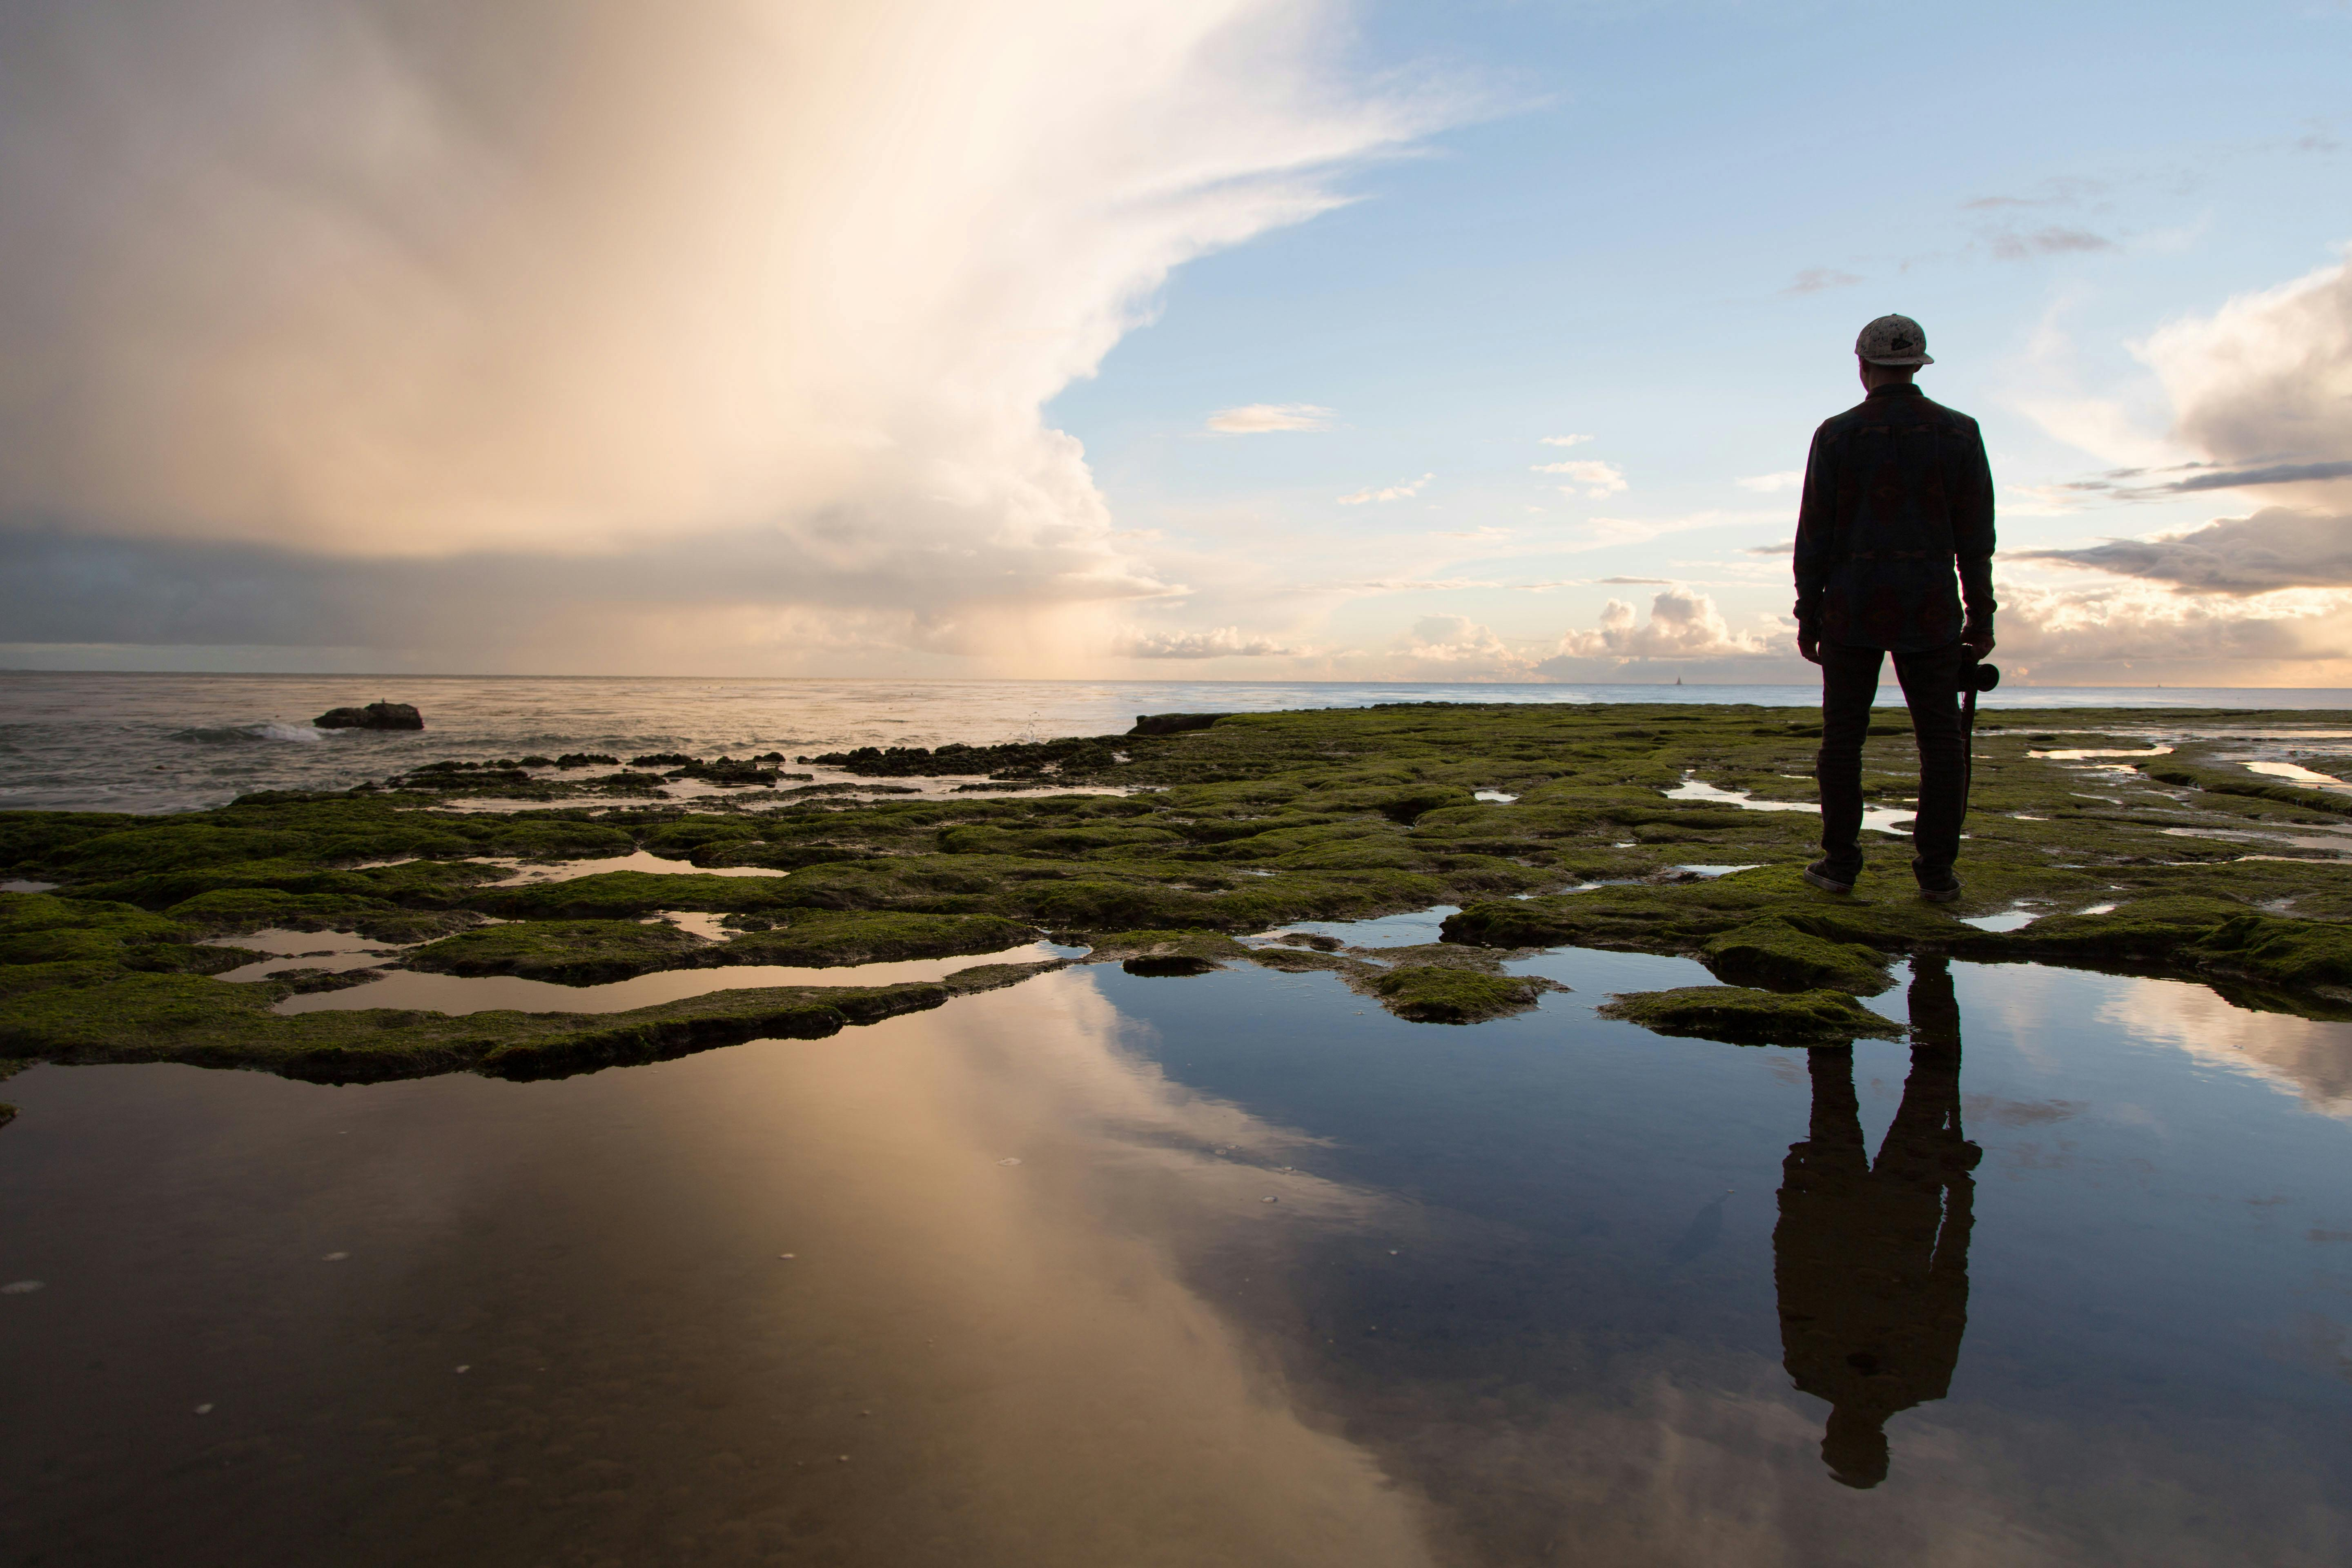

In [14]:
from IPython.display import Image, display

TEST_IMAGE_PATH = r"C:\Users\pablosal\Desktop\gbbai-azure-ai-agentic-frameworks\utils\data\lake-man-person-7054.jpg"
PROMPT = "Remove the person from the image."

display(Image(filename=TEST_IMAGE_PATH, width=300, height=200))

In [9]:
bounding_boxes = generate_tags_and_boxes(image_path=TEST_IMAGE_PATH)
print(bounding_boxes)

2024-09-03 11:36:35,484 - micro - MainProcess - INFO     Initialized ImageAnalysisClient with endpoint: https://east-us-vision-inpainting.cognitiveservices.azure.com/ (inpainting.py:generate_tags_and_boxes:187)
INFO:micro:Initialized ImageAnalysisClient with endpoint: https://east-us-vision-inpainting.cognitiveservices.azure.com/
2024-09-03 11:36:35,486 - micro - MainProcess - INFO     Analyzing image from local path: C:\Users\pablosal\Desktop\gbbai-azure-ai-agentic-frameworks\utils\data\lake-man-person-7054.jpg (inpainting.py:generate_tags_and_boxes:197)
INFO:micro:Analyzing image from local path: C:\Users\pablosal\Desktop\gbbai-azure-ai-agentic-frameworks\utils\data\lake-man-person-7054.jpg
2024-09-03 11:36:36,896 - micro - MainProcess - INFO     Image analysis completed. (inpainting.py:generate_tags_and_boxes:206)
INFO:micro:Image analysis completed.
2024-09-03 11:36:36,899 - micro - MainProcess - INFO     Detected 1 objects in the image. (inpainting.py:generate_tags_and_boxes:209)


[{'box': [4391, 736, 4896, 2190], 'confidence': 0.893, 'tag': 'person'}]


In [13]:
response_sam = sam(image=image_to_base64(TEST_IMAGE_PATH), bounding_box=bounding_boxes[0]["box"])

2024-09-03 11:38:18,006 - micro - MainProcess - INFO     Making request to SAM model with URL: https://ovv-sam.eastus2.inference.ml.azure.com/score (inpainting.py:sam:275)
INFO:micro:Making request to SAM model with URL: https://ovv-sam.eastus2.inference.ml.azure.com/score
2024-09-03 11:38:57,526 - micro - MainProcess - INFO     SAM model request successful. (inpainting.py:sam:280)
INFO:micro:SAM model request successful.


In [15]:
import json
sam_data = json.loads(response_sam.decode('utf-8'))
mask_base64 = sam_data[0]["response"]["predictions"][0]["masks_per_prediction"][0]["encoded_binary_mask"]
inpainting_result = inpainting(image_to_base64(TEST_IMAGE_PATH), mask_base64, PROMPT)
inpainting_data = json.loads(inpainting_result.decode('utf-8'))
generated_image_base64 = inpainting_data[0]["generated_image"]

ConnectionError: HTTPSConnectionPool(host='ovv-inpainting.eastus2.inference.ml.azure.com', port=443): Max retries exceeded with url: /score (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000247D8D815E0>: Failed to resolve 'ovv-inpainting.eastus2.inference.ml.azure.com' ([Errno 11001] getaddrinfo failed)"))

## Agentic Orchestration

In this section, we will use Agentic Orchestration with AutoGen as a framework to automate the inpainting process. This approach leverages domain-specific agents capable of autonomously making decisions about the inpainting process using the tools available above.

### How It Works

1. **Domain-Specific Agents**: We will create agents with specific capabilities to handle different stages of the inpainting process. These agents will be able to:
   - Detect objects in the image and generate bounding boxes.
   - Segment the identified objects and create masks.
   - Perform the inpainting operation to fill in the specified areas of the image based on the provided prompt.
   - Refine the inpainted image to enhance its quality and realism.

2. **Autonomous Decision-Making**: The agents will be capable of making autonomous decisions about the inpainting process. For example, an agent might decide to eliminate an empty bounding box or choose the best mask for inpainting based on confidence scores.

3. **Integration with AutoGen**: AutoGen will be used as the framework to create, manage, and orchestrate the agents. This includes defining the roles and responsibilities of each agent, as well as the communication and coordination between them.


## Testing 101 Orchestartion flow (WIP)

In [20]:
import os
import subprocess

user_base_path = r"C:\Users\pablosal\Desktop\gbbai-azure-ai-agentic-frameworks"

image_relative_path = r"utils\data\lake-man-person-7054.jpg"
IMAGE_PATH = os.path.join(user_base_path, image_relative_path)
PROMPT = "Remove the person from the image."

CONDA_ENV = "agentic-framework"
PYTHON_INTERPRETER = "python"

os.environ['PYTHONPATH'] = os.getcwd()
script_relative_path = r"src\app\testflow.py"
script_path = os.path.join(user_base_path, script_relative_path)

command = f"{PYTHON_INTERPRETER} {script_path} --image_path {IMAGE_PATH} --prompt \"{PROMPT}\""

activate_env_command = f"conda activate {CONDA_ENV} && {command}"

result = subprocess.run(activate_env_command, shell=True, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)

Logging session started with ID: 22561eeb-6d79-467e-aa4c-c8a871c4ac6c
Planner (to Image Editor):

Image Path: C:\Users\pablosal\Desktop\gbbai-azure-ai-agentic-frameworks\utils\data\lake-man-person-7054.jpg
Prompt: Remove the person from the image.

--------------------------------------------------------------------------------
Image Editor (to Planner):

***** Suggested tool call (call_ZLIGh5kCr9TKHEVQXNwbw17u): generate_tags_and_boxes *****
Arguments: 
{"image_path":"C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-agentic-frameworks\\utils\\data\\lake-man-person-7054.jpg"}
****************************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Planner (to Image Editor):

Planner (to Image Editor):

***** Response from calling tool (call_ZLIGh5kCr9TKHEVQXNwbw17u) *****
Error: Function generate_tags_and_boxes not found.
******************************************